# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.527240,True,8.285377
1,-0.110830,True,5.784838
2,2.377103,True,7.489729
3,1.116029,False,1.940592
4,1.636348,True,5.878136
...,...,...,...
995,1.469121,True,6.678857
996,-0.557878,True,3.941627
997,0.089960,True,5.844339
998,1.425688,True,6.646875


<Axes: xlabel='v0'>

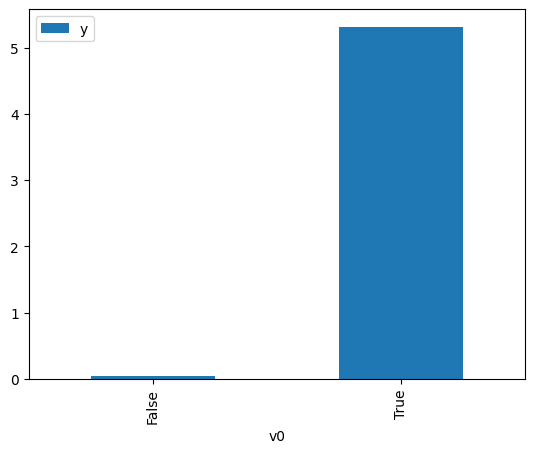

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

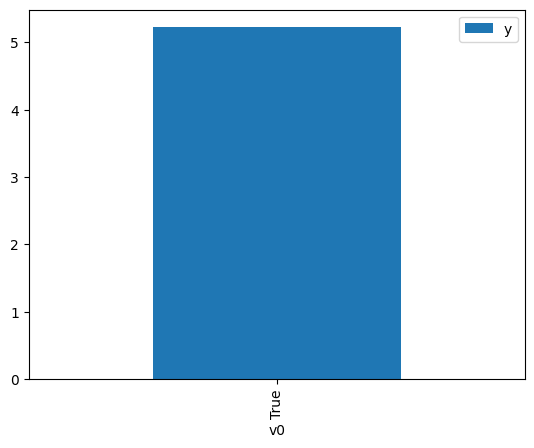

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-2.086289,False,-3.152746,0.989874,1.010229
1,0.762198,False,0.527814,0.146937,6.805631
2,1.410007,False,0.427368,0.039128,25.556846
3,0.059291,False,-0.295065,0.451650,2.214104
4,-1.477469,False,-2.444125,0.961843,1.039670
...,...,...,...,...,...
995,-0.554092,False,-0.861449,0.763419,1.309896
996,1.410007,False,0.427368,0.039128,25.556846
997,0.858859,False,0.823184,0.121958,8.199537
998,-1.390263,False,-1.655598,0.954043,1.048170


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.058531,True,4.412841,0.482934,2.070676
1,0.908917,True,5.978605,0.889482,1.124250
2,-1.036069,True,2.622728,0.095825,10.435711
3,-0.142358,True,5.611390,0.436616,2.290343
4,-0.218788,True,4.407816,0.395307,2.529678
...,...,...,...,...,...
995,-0.949776,True,3.933958,0.113811,8.786516
996,1.554542,True,8.360527,0.971328,1.029518
997,-1.036069,True,2.622728,0.095825,10.435711
998,0.841040,True,4.865360,0.873730,1.144518


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.951
Model:                            OLS   Adj. R-squared (uncentered):              0.951
Method:                 Least Squares   F-statistic:                              9619.
Date:                Fri, 22 Dec 2023   Prob (F-statistic):                        0.00
Time:                        07:22:01   Log-Likelihood:                         -1426.2
No. Observations:                1000   AIC:                                      2856.
Df Residuals:                     998   BIC:                                      2866.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.3226      0.036     37.055      0.000       1.253       1.393
x2             4.9950      0.050     99.931      0.000       4.897       5.093
==============================================================================
Omnibus:                        1.894   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.388   Jarque-Bera (JB):                1.784
Skew:                          -0.099   Prob(JB):                        0.410
Kurtosis:                       3.060   Cond. No.                         1.87
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""